<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# RNN Text Classifier

by Fabian Märki

## Summary
The aim of this notebook is to program a RNN text classifier. Additionally, it sets the stage for a later hyperparameter tuning also allowing for model design optimization.

<a href="https://colab.research.google.com/github/markif/2021_HS_DAS_NLP_Notebooks/blob/master/06_a_RNN_Text_Classifier.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install 'fhnw-nlp-utils>=0.1.6,<0.2'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.colab import runs_on_colab

import numpy as np
import pandas as pd

import tensorflow as tf

print("Tensorflow version:", tf.__version__)

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Tensorflow version: 2.5.1
GPU is available


In [2]:
%%time
download("https://drive.google.com/uc?id=19AFeVnOfX8WXU4_3rM7OFoNTWWog_sb_", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

download("https://drive.google.com/uc?id=1tT2dj70GLi2bJYg4j3g1MIglGXTDAugI", "data/german_doctor_reviews_augmented_tokenized.parq")
data_aug = load_dataframe("data/german_doctor_reviews_augmented_tokenized.parq")

CPU times: user 14.7 s, sys: 2.32 s, total: 17 s
Wall time: 8.99 s


In [3]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [4]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [5]:
data_aug.head(3)

,text_original,rating,sentiment,text,label,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."


In [6]:
from fhnw.nlp.utils.ploting import plot_history

from fhnw.nlp.utils.params import build_model_cnn
from fhnw.nlp.utils.params import build_model_rnn
from fhnw.nlp.utils.params import compile_model
from fhnw.nlp.utils.params import create_label_binarizer_and_set
from fhnw.nlp.utils.params import dataframe_to_dataset
from fhnw.nlp.utils.params import extract_embedding_layer_and_set
from fhnw.nlp.utils.params import extract_text_vectorization_and_set
from fhnw.nlp.utils.params import extract_vocabulary_and_set
from fhnw.nlp.utils.params import get_train_test_split
from fhnw.nlp.utils.params import re_compile_model
from fhnw.nlp.utils.params import save_model
from fhnw.nlp.utils.params import train_model

In [7]:
params = {
    "verbose": True,
    "shuffle": True,
    "batch_size": 128,
    "X_column_name": "text_clean",
    "y_column_name": "label",
    "embedding_type": "fasttext",
    #"embedding_type": "bytepair",
    "embedding_dim": 300,
    "embedding_mask_zero": True,
    "embedding_trainable": False,
    #"embedding_input_sequence_length": output_sequence_length if 'output_sequence_length' in locals() or 'output_sequence_length' in globals() else None,
    "embedding_fasttext_model": "cc.de.300.bin",
    "embedding_word2vec_model_url": "https://cloud.devmount.de/d2bc5672c523b086/german.model",
    "embedding_spacy_model": "de_core_news_md",
    "embedding_tensorflow_hub_url": "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2",
    "model_type": "rnn",
}

if runs_on_colab() and params["embedding_type"] == "fasttext":
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.google.com/uc?id=1iqw8UPEEVmzQQGmI5FkRJH8B5SkZCgXG", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name
    

In [8]:
all_data = pd.concat([data, data_aug])
#all_data = data

In [9]:
create_label_binarizer_and_set(params, all_data)
extract_vocabulary_and_set(params, all_data)

Inferred classification type: binary
Median sequence length: 58
Percentil (0.98) cutoff sequence length: 301
Max sequence length: 408
Used embedding sequence length: 301


In [10]:
extract_text_vectorization_and_set(params)

Vocabulary length: 205493


In [11]:
%%time

extract_embedding_layer_and_set(params)

Number of null word embeddings:  14
Words not found in total:  14
Words without embedding (14/14): ["'t", 'wã', '', '``', 'èn', 'úm', 'jé', "''", 'öä', 'üw', "'s", 'ìn', 'äk', 'öz']
CPU times: user 6.42 s, sys: 4.64 s, total: 11.1 s
Wall time: 13.8 s


Prepare the training/test/validation data

In [12]:
data_train, data_test = get_train_test_split(params, data)
data_train = pd.concat([data_train, data_aug])
data_train, data_val = get_train_test_split(params, data_train)

dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

264949 train examples
66238 test examples
449506 train examples
112377 test examples


In [13]:
for text, labels in dataset_train.take(1):
    print(text)
    print(labels)

{'text_clean': <tf.Tensor: shape=(128,), dtype=string, numpy=
array([b'leider keine gute erfahrungen mit dr. feilscher . obwohl das praxisteam sehr engagiert erscheint , hat der doktor keine minuten zeit , um sich genauer seine patienten anzusehen . nach pr\xc3\xbcfung externer dritter wurde bei mir regelm\xc3\xa4\xc3\x9fig medizinische probleme \xc3\xbcbersehen und letzen endes eine vermeidbare op fehlerhaft durchgef\xc3\xbchrt . definitiv nicht zu empfehlen !',
       b'ich bin seit vielen jahren patient bei dr. b\xc3\xb6hm und bin immer noch bei ihm , das sagt im grunde alles aus . seine art mit menschen umzugehen ist einfach hervorragend . seine praxismitarbeiterin sind ebenfalls schon seit jahren bei ihm , was auch hier zeigt , das das innenverh\xc3\xa4ltnis in der praxis top ist .',
       b'ich habe schon einige zahn\xc3\xa4rzte besucht und wurde nie zufrieden gestellt ! bei diesem zahnarzt war das anders . er nahm sich zeit , hat sich f\xc3\xb6rmlich verbogen um mir eine angene

In [15]:
def build_model_rnn_simple(params):
    """Builds a rnn classifier (only partially) based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    from tensorflow import keras
    
    classification_type = params.get("classification_type", "binary")
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    
    model = keras.Sequential(name="rnn")
    # A text input
    model.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name="text_input"))
    # The first layer in our model is the vectorization layer. After this layer,
    # we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(vectorize_layer)
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model.add(embedding_layer)
    
    rnn_units = 32
    model.add(keras.layers.Bidirectional(
        # dropout (regularization) could make sense here
        keras.layers.LSTM(
            rnn_units, 
            return_sequences=True # needed since we do a GlobalMaxPool1D
        )
    ))
    
    model.add(keras.layers.GlobalMaxPool1D(name="global_max_pool"))
    
    # do not forget Dropout (regularization) for a more sophisticated model
    model.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    
    return model
    

def build_model_rnn(params):
    """Builds a rnn classifier based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    from tensorflow import keras
    
    rnn_activation_function = params.get("rnn_activation_function", "relu")
    rnn_output_dropout = params.get("rnn_output_dropout", 0.5)
    rnn_dropout = params.get("rnn_dropout", 0.2)
    # for values > 0 it will not use cuDNN kernels
    rnn_recurrent_dropout = params.get("rnn_recurrent_dropout", 0.0)
    rnn_units = params.get("rnn_units", 32)
    rnn_num_layers = params.get("rnn_num_layers", 1)
    rnn_bidirectional = params.get("rnn_bidirectional", True)
    rnn_type = params.get("rnn_type", "LSTM")
    rnn_global_max_pooling = params.get("rnn_global_max_pooling", False)

    classification_type = params.get("classification_type", "binary") 
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    model = keras.Sequential(name="rnn")
    # A text input
    model.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name="text_input"))
    # The first layer in our model is the vectorization layer. After this layer,
    # we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(vectorize_layer)
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model.add(embedding_layer)
    
    for layer in range(rnn_num_layers):
        return_sequences = layer + 1 < rnn_num_layers or rnn_global_max_pooling
        
        if rnn_type == "LSTM":
            layer = keras.layers.LSTM(rnn_units, return_sequences=return_sequences, dropout=rnn_dropout, recurrent_dropout=rnn_recurrent_dropout)
        elif rnn_type == "GRU":
            layer = keras.layers.GRU(rnn_units, return_sequences=return_sequences, dropout=rnn_dropout, recurrent_dropout=rnn_recurrent_dropout)
        elif rnn_type == "RNN":
            layer = keras.layers.RNN(rnn_units, return_sequences=return_sequences)
        else:
            raise ValueError("Unknown rnn_type "+rnn_type)
        
        
        if rnn_bidirectional:
            layer = keras.layers.Bidirectional(layer)
         
        model.add(layer)
        
        rnn_units = int(rnn_units / 2)
    
    if rnn_global_max_pooling:
        model.add(keras.layers.GlobalMaxPool1D(name="global_max_pool"))
    
    model.add(keras.layers.Dense(rnn_units, activation=rnn_activation_function))
    
    if rnn_output_dropout is not None and rnn_output_dropout > 0:
        model.add(keras.layers.Dropout(rnn_output_dropout, name="dense_dropout"))
        
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise ValueError("Unknown classification_type "+classification_type)

    model.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    
    return model

**Note: The run you see below it from a build_model_rnn_simple(...) model (i.e. your output will look different)!**

In [16]:
model = build_model_rnn(params)
#model = build_model_rnn_simple(params)
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         61647900  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          85248     
_________________________________________________________________
global_max_pool (GlobalMaxPo (None, 64)                0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 65        
Total params: 61,733,213
Trainable params: 85,313
Non-trainable params: 61,647,900
_________________________________________________________________


In [17]:
compile_model(params, model)

In [18]:
params["training_epochs"] = 10
history = train_model(params, model, dataset_train, dataset_val)

Epoch 1/10
3512/3512 [==============================] - 138s 37ms/step - loss: 0.0937 - accuracy: 0.9676 - val_loss: 0.0666 - val_accuracy: 0.9793
Epoch 2/10
3512/3512 [==============================] - 132s 37ms/step - loss: 0.0542 - accuracy: 0.9832 - val_loss: 0.0507 - val_accuracy: 0.9854
Epoch 3/10
3512/3512 [==============================] - 130s 37ms/step - loss: 0.0405 - accuracy: 0.9879 - val_loss: 0.0506 - val_accuracy: 0.9852
Epoch 4/10
3512/3512 [==============================] - 129s 37ms/step - loss: 0.0322 - accuracy: 0.9904 - val_loss: 0.0447 - val_accuracy: 0.9876
Epoch 5/10
3512/3512 [==============================] - 129s 37ms/step - loss: 0.0262 - accuracy: 0.9923 - val_loss: 0.0472 - val_accuracy: 0.9875
Epoch 6/10
3512/3512 [==============================] - 130s 37ms/step - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.0473 - val_accuracy: 0.9886
Epoch 7/10
3512/3512 [==============================] - 129s 37ms/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 0

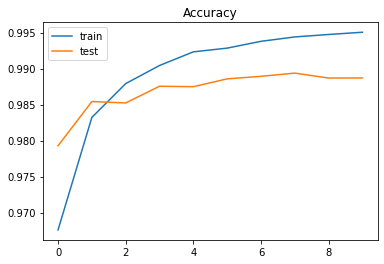

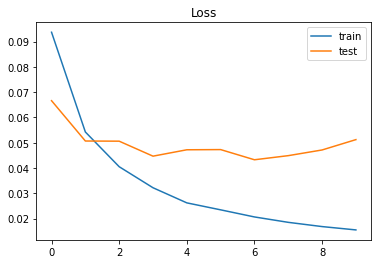

In [19]:
plot_history(history)

Quite overfitted. Training could stop after ~3 epochs and some regularizations (like dropout) could also make sense.  

**Node: Following output is from a build_model_rnn(...) run!**

Let's see if it is possible to further improve the model by unfreezing the embedding layer.

Also see https://www.tensorflow.org/guide/keras/transfer_learning

In [18]:
# Unfreeze all layers (i.e. make embeddings trainable)
model.trainable = True
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         61647900  
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_dropout (Dropout)      (None, 16)                0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 17        
Total params: 61,734,205
Trainable params: 61,734,205
Non-trainable params: 0
___________________________________________________

In [19]:
re_compile_model(params, model)

In [20]:
params["training_epochs"] = 2
history = train_model(params, model, dataset_train, dataset_val)

Epoch 1/2
3512/3512 [==============================] - 1638s 465ms/step - loss: 0.0385 - accuracy: 0.9883 - val_loss: 0.0364 - val_accuracy: 0.9896
Epoch 2/2
3512/3512 [==============================] - 1622s 462ms/step - loss: 0.0313 - accuracy: 0.9906 - val_loss: 0.0349 - val_accuracy: 0.9905


In [21]:
save_model(params, model, history)

INFO:tensorflow:Assets written to: models/rnn/20210918-164935/model_0.99048/assets


INFO:tensorflow:Assets written to: models/rnn/20210918-164935/model_0.99048/assets


In [22]:
#%tensorboard --logdir logs

In [23]:
from fhnw.nlp.utils.ploting import report_classification_results

Check performance on all data.

Set Population: 331187
Accuracy: 0.9872


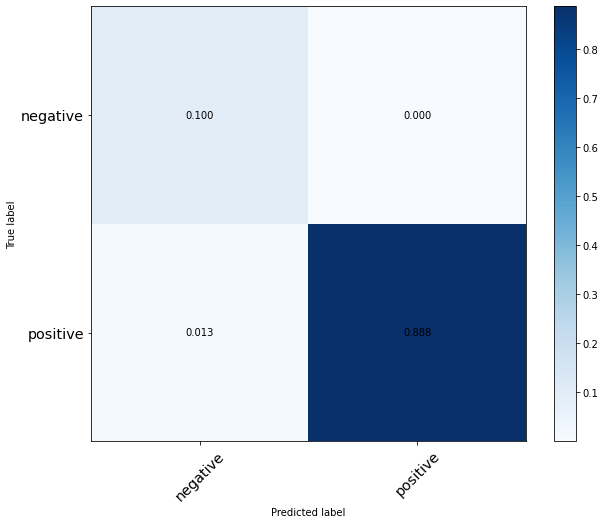

              precision    recall  f1-score   support

    negative       0.89      1.00      0.94     33022
    positive       1.00      0.99      0.99    298165

    accuracy                           0.99    331187
   macro avg       0.94      0.99      0.97    331187
weighted avg       0.99      0.99      0.99    331187

CPU times: user 1min 58s, sys: 1.54 s, total: 1min 59s
Wall time: 49 s


In [24]:
%%time

report_classification_results(params, data, model)

Check performance on test data.

Set Population: 66238
Accuracy: 0.9822


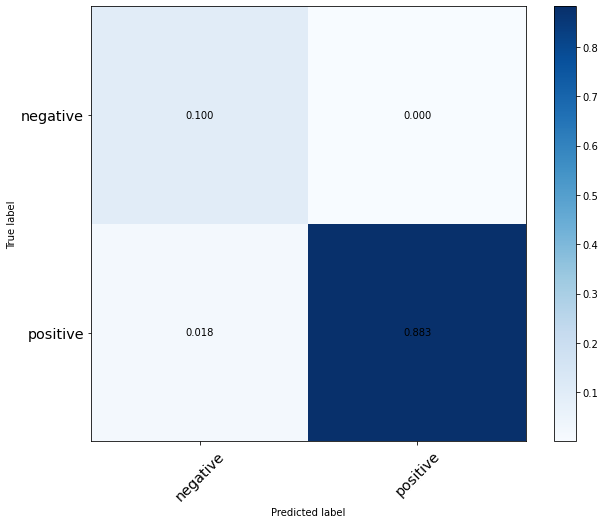

              precision    recall  f1-score   support

    negative       0.85      1.00      0.92      6604
    positive       1.00      0.98      0.99     59634

    accuracy                           0.98     66238
   macro avg       0.92      0.99      0.95     66238
weighted avg       0.98      0.98      0.98     66238

CPU times: user 23.2 s, sys: 243 ms, total: 23.4 s
Wall time: 9.11 s


In [25]:
%%time

report_classification_results(params, data_test, model)